Perform all imports and necessary variable initialization


In [11]:
import pandas as pd
urls = {
    "start":"https://raw.githubusercontent.com/clear-street/datasci-screening-nedstarksbastard/fizi_screen/data/start.csv?token=ADXBUQYU2LDRT7DTNLZEWQS6A6K7U",
    "trade":"https://raw.githubusercontent.com/clear-street/datasci-screening-nedstarksbastard/fizi_screen/data/trades.csv?token=ADXBUQZKQ56AHBMLLSQ4RLK6A6LMC",
    "table":"https://raw.githubusercontent.com/clear-street/datasci-screening-nedstarksbastard/fizi_screen/data/table.html?token=ADXBUQ34M63OTOGHA7QOSCC6A6LKA"
}


Read start positions for Symbols into dataframe

In [12]:
df_sod = pd.read_csv(urls["start"], names=["Symbol", "Position"])
df_sod


,Symbol,Position
0,MMM,293738
1,ABT,-306281
2,ABBV,-696534
3,AAP,-638384
4,AES,724516
...,...,...
358,XRX,-799141
359,XYL,834040
360,YUM,-802279
361,ZBH,540668


Read today's positions into a dataframe

In [13]:
df_intra_day = pd.read_csv(urls["trade"], names=["Symbol", "Position"])
df_intra_day


,Symbol,Position
0,CAT,847533
1,EL,162298
2,KMX,220487
3,NSC,965676
4,PM,636000
...,...,...
18628,CXO,-693011
18629,AGN,775227
18630,GPN,394318
18631,CNC,322371


Generate end-of-day positions for all Symbols

In [14]:
df_intra_day_agg = df_intra_day.groupby("Symbol").sum().reset_index()
df_eod = df_sod.set_index('Symbol').add(df_intra_day_agg.set_index('Symbol'), fill_value=0).reset_index()
df_eod["Position"] = df_eod["Position"].astype('int64')
df_eod


,Symbol,Position
0,A,1864817
1,AAP,-3298989
2,ABBV,-1556626
3,ABC,2436387
4,ABT,878535
...,...,...
371,XRX,951896
372,XYL,-359012
373,YUM,-3013298
374,ZBH,187439


Read the html table containing Symbol info into dataframe

In [15]:
df_info = pd.read_html(urls["table"])[0]
df_info


,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,reports,Industrials,Industrial Machinery,"White Plains, New York",2011-11-01,1524472,NaN
501,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,NaN
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,NaN
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,NaN


Generate sector dataframe with aggregates of positions per sector

In [16]:
df_sectrs = pd.merge(df_info, df_eod, on="Symbol").groupby('GICS Sector')['Position'].sum().reset_index()
df_sectrs


,GICS Sector,Position
0,Communication Services,17543418
1,Consumer Discretionary,-29123263
2,Consumer Staples,31028909
3,Energy,20474677
4,Financials,47425709
5,Health Care,36026170
6,Industrials,8244436
7,Information Technology,17527762
8,Materials,-29528000
9,Real Estate,-20684352


Generate coordinates for the headquarters. This takes considerable time despite only sending requests for unique 
addresses so if you lack the patience then skip this step. We will read from a pre-generated csv file in the next 
step that contains latitude and longitude information for the headquarter

In [17]:
import geopy
from geopy.extra.rate_limiter import RateLimiter

locator = geopy.Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
df_info = pd.read_html(urls["table"])[0]
hqs = df_info["Headquarters Location"].unique()
d = dict(zip(hqs, pd.Series(hqs).apply(geocode)))
df_info["Location Info"] = df_info["Headquarters Location"].map(d)

df_info['Point'] = df_info['Location Info'].apply(lambda loc: tuple(loc.point) if loc else None)
df_info[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(df_info['Point'].tolist(), index=df_info.index)
df_info = df_info.drop(["Location Info", "Point"], axis=1)
df_info


,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded,Latitude,Longitude,Altitude
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902,44.950404,-93.101503,0.0
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,42.325578,-87.841182,0.0
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),42.325578,-87.841182,0.0
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,42.575095,-70.930051,0.0
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,53.349764,-6.260273,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,reports,Industrials,Industrial Machinery,"White Plains, New York",2011-11-01,1524472,NaN,41.033986,-73.762910,0.0
501,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,NaN,38.254238,-85.759407,0.0
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,NaN,41.238102,-85.853054,0.0
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,NaN,40.767013,-111.890431,0.0


Or read it from the generated csv files

In [18]:
df_info = pd.read_html(urls["table"])[0]
df_loc = pd.read_csv('data/location.csv', names=['Symbol', 'Latitude', 'Longitude', 'Altitude'])
df_info = pd.merge(df_info, df_loc, on="Symbol")
df_info


,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded,Latitude,Longitude,Altitude
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902,44.950404,-93.101503,0.0
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,42.325578,-87.841182,0.0
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),42.325578,-87.841182,0.0
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,42.575095,-70.930051,0.0
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,53.349764,-6.260273,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,reports,Industrials,Industrial Machinery,"White Plains, New York",2011-11-01,1524472,NaN,41.033986,-73.762910,0.0
501,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,NaN,38.254238,-85.759407,0.0
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,NaN,41.238102,-85.853054,0.0
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,NaN,40.767013,-111.890431,0.0


Render map using the coordinates

In [19]:
import folium
df_info = df_info.dropna(subset=['Latitude'])
hq_map = folium.Map(location=[44.950404, -93.101503], tiles='cartodbpositron',zoom_start=12)
df_info.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(hq_map), axis=1)
hq_map

Get last business day's close price for all Symbols (few missing based on API, ignore the warnings). 
A better approach will be to gather the ones not found by the current source and try different sources till all found 
but not required for current task.This takes is also time consuming so you can skip it and directly read from the 
pre-generated csv file in the next block

In [20]:
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
last_biz_day = pd.datetime.today() - BDay()
df_sym_close = web.DataReader(df_info['Symbol'].to_list(), 'yahoo', last_biz_day.strftime("%Y/%m/%d")).iloc[0]['Close'].reset_index()
df_sym_close.columns = ["Symbol", "Close"]
df_sym_close

c:\dev\pycharmprojects\datasci-screening-nedstarksbastard\venv\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'APC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
c:\dev\pycharmprojects\datasci-screening-nedstarksbastard\venv\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'BHGE', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
c:\dev\pycharmprojects\datasci-screening-nedstarksbastard\venv\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'BBT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
c:\dev\pycharmprojects\datasci-screening-nedstarksbastard\venv\lib\site-packages\pandas_datareader\base.py:270: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
c:\dev\pycharmprojects\datasci-screening-nedstarksbastard\venv\lib\site-packages\pandas_datareade

,Symbol,Close
0,MMM,175.369995
1,ABT,86.660004
2,ABBV,89.290001
3,ABMD,162.889999
4,ACN,211.100006
...,...,...
496,STI,NaN
497,SYMC,NaN
498,TMK,NaN
499,TSS,NaN


Read close prices for last business day from pre-generated csv

In [21]:
df_sym_close = pd.read_csv('data/close_price.csv', names=['Symbol', 'Close'])
df_sym_close

,Symbol,Close
0,MMM,175.369995
1,ABT,86.660004
2,ABBV,89.290001
3,ABMD,162.889999
4,ACN,211.100006
...,...,...
500,STI,NaN
501,SYMC,NaN
502,TMK,NaN
503,TSS,NaN


Calculate total value by multiplying number of stocks with price per stock

In [22]:
df_eod = pd.merge(df_eod, df_sym_close, on="Symbol")
df_eod["Total"] = df_eod["Position"] * df_eod["Close"]
df_eod

,Symbol,Position,Close,Total
0,A,1864817,85.190002,1.588638e+08
1,AAP,-3298989,158.119995,-5.216361e+08
2,ABBV,-1556626,89.290001,-1.389911e+08
3,ABC,2436387,85.669998,2.087253e+08
4,ABT,878535,86.660004,7.613385e+07
...,...,...,...,...
371,XRX,951896,37.349998,3.555331e+07
372,XYL,-359012,78.610001,-2.822193e+07
373,YUM,-3013298,100.589996,-3.031076e+08
374,ZBH,187439,150.320007,2.817583e+07


Plot the 10 best performers

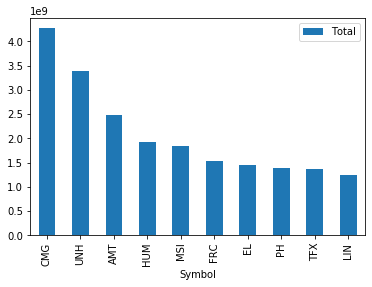

In [23]:
import matplotlib.pyplot as plt
df_eod.nlargest(10, ['Total']).plot(x="Symbol", y=["Total"], kind="bar")
plt.show()
